## **Titanic Project**

### Introduction
In this project, we will use feature engineering and ensemble method to predict the survival of passengers on Titanic.

### **Step 0: Set Up**

---




In [1]:
import pandas as pd
import numpy as np
import sklearn
import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import KFold
from sklearn.base import clone

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

import numpy as np
import io

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 

from plotly.offline import iplot
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### **Step 1: Import and Examine Train and Test Data Set**

---



#### **1.a Import train and test data set, data types of columns**

In [ ]:
from google.colab import files
uploaded = files.upload()
df_train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
df_train.head()

Saving train.csv to train (6).csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
uploaded = files.upload()
df_test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))
df_test.head()

Saving test.csv to test (6).csv


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
#data type of each column in train set
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
#data type of each column in test set
df_test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### **1.b Examine and clean outliers in training set**

In [ ]:
##Using interquartile range rule to find values of outliers of numeric variables 'SibSp', 
#number of siblings/spouses aboard, and 'Fare', ticket price.
#Printing all outliers in columns 'SibSp' and 'Fare' and their indexes in a series 'outliers'.
df_num_train = ['Pclass','SibSp', 'Fare']
outliers = pd.Series([])
for x in df_num_train:
  quarter = df_train[x].quantile([0.25, 0.75])
  iqr = quarter[0.75] - quarter[0.25]
  upper_fence = quarter[0.75] + iqr*1.5
  lower_fence = quarter[0.25] - iqr*1.5
  outlier = df_train[x][(df_train[x] > upper_fence) | (df_train[x] < lower_fence)]
  outliers = outliers.append(outlier)
print(outliers)

7        3.0000
16       4.0000
24       3.0000
27       3.0000
50       4.0000
         ...   
846     69.5500
849     89.1042
856    164.8667
863     69.5500
879     83.1583
Length: 162, dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [ ]:
# Getting rid of rows that are outliers in both 'SibSp' and 'Fare'.
count = outliers.index.value_counts()
outlier_index = count[count == 2].index
df_train_cleaned = df_train.drop(outlier_index, axis=0, inplace=False)
df_train_cleaned = df_train_cleaned.reset_index(drop=True)
df_train_cleaned.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
df_train_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### **1.c Examine and clean null values**

##### **i. Train Set**

In [ ]:
#Examine number of null values in training set
df_train_cleaned.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

From the null value count above, we can see that by eliminating outliers, we elimited 7 null values in both age and cabin. In addition, there are 2 missing values in embarked, we will take a look at how to deal with them.

In [ ]:
#Value counts of Embarked in training set
print(df_train_cleaned['Embarked'].value_counts())

S    634
C    168
Q     77
Name: Embarked, dtype: int64


Because only 2 out of 881 'Embarked' values are missing, we decide to fill missing values in with 'S', the value with highest frequency in 'Embarked'.

In [ ]:
#Fill in missing values in Embarked.
df_train_cleaned['Embarked'] = df_train_cleaned['Embarked'].fillna('S')
print(df_train_cleaned['Embarked'].value_counts())

S    636
C    168
Q     77
Name: Embarked, dtype: int64


680 data is missing a value for 'Cabin', meaning these passengers had no cabin. Therefore we will fill in strin 'No Cabin' for these values.

In [ ]:
#Fill in missing values in Cabin.
df_train_cleaned['Cabin'] = df_train_cleaned['Cabin'].fillna('No Cabin')
df_train_cleaned.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

For the 170 missing age values, we do not think getting rid of them is a good idea as 170 is a large amount of data considering the whole data set. Therefore, we will find features that may be correlated with age, and try to fill in age values later in the project.

##### **ii. Test Set**

In [ ]:
#Examine number of null values in test set
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

There is only 1 null value in Fare, and we decide to fill it in with the mean of Fare.

In [ ]:
#Fill in null value for 'Fare' in the test set.
df_test['Fare'] = df_test['Fare'].fillna(np.mean(df_test['Fare']))
df_test_cleaned = df_test
df_test_cleaned.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64

Same reason as in the train set, we will fill in 'No Cabin' for missing Cabin values in the test set.

In [ ]:
#Fill in missing values in Cabin.
df_test_cleaned['Cabin'] = df_test_cleaned['Cabin'].fillna('No Cabin')
df_test_cleaned.isnull().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Cabin           0
Embarked        0
dtype: int64

For the 86 missing age values in the test set, we will find features that may be correlated with age, and try to fill in age values later in the project.

### **Step 2: Features relationship with Target Variable 'Survived', Feature Engineering**

---



#### **2.a Relationship with Survived: Sex**

In [ ]:
#Change 'Sex' into dummy variables for the train set, 1 is male, 0 is female.
le = LabelEncoder()
df_train_cleaned['Sex'] = le.fit_transform(df_train_cleaned['Sex'])

In [ ]:
#Change 'Sex' into dummy variables for the test set, 1 is male, 0 is female
le = LabelEncoder()
df_test_cleaned['Sex'] = le.fit_transform(df_test_cleaned['Sex'])

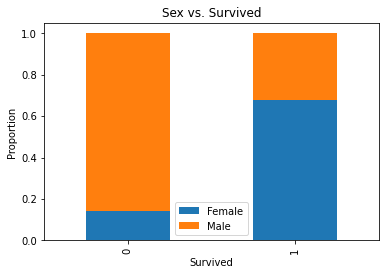

In [ ]:
#Plotting a crosstab to see relationship between gender and survival in the train set.
ss = pd.crosstab(df_train_cleaned['Survived'],df_train_cleaned['Sex']).apply(lambda r: r/r.sum(), axis=1)
ss.plot.bar(stacked=True)
plt.ylabel('Proportion')
plt.legend(['Female', 'Male'])
plt.title("Sex vs. Survived");

From the plot above, we can see that among the survived population, 68% were female. Among the population that did not survive, 85% were male. The proportion of each gender that survived differs by a lot and we should include gender as one of the features to train our model.

#### **2.b Relationship with Survived: Name**

In [ ]:
#Get prefix in names and column 'Prefix' in each data set for prefix.
prefix_train = [i.split(",")[1].split(".")[0].strip() for i in df_train_cleaned["Name"]]
title = [i.split(",")[1].split(".")[0].strip() for i in df_train["Name"]]
prefix_test = [i.split(",")[1].split(".")[0].strip() for i in df_test_cleaned["Name"]]
df_train_cleaned["Prefix"] = pd.Series(prefix_train)
df_test_cleaned["Prefix"] = pd.Series(prefix_test)

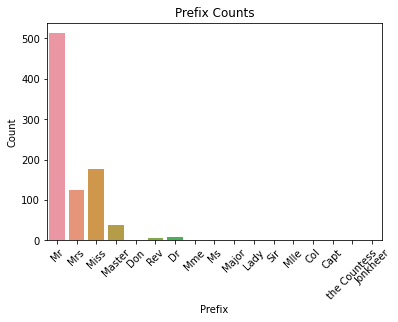

In [ ]:
#Graphing frequency of each prefix in the training set.
g = sns.countplot(x="Prefix",data=df_train_cleaned)
g = plt.setp(g.get_xticklabels(), rotation=45)
plt.ylabel("Count") 
plt.title("Prefix Counts");

We can see that over 500 data has prefix Mr. We decied to categorize data into 4 categories: Mr, Female, Unmarried and Esteemed.

In [ ]:
#Unique values in prefix for train set
df_train_cleaned['Prefix'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [ ]:
#Categorizing prefix into Female, Unmarried and Esteemed. Prefix Mr. is its own category as majority of the prefixes are Mr.
df_train_cleaned["Prefix"] = df_train_cleaned["Prefix"].replace(['Lady', 'the Countess', 'Ms', 'Mrs', 'Mlle'], 'Female')
df_train_cleaned["Prefix"] = df_train_cleaned["Prefix"].replace(['Master', 'Miss', 'Mme'], 'Unmarried')
df_train_cleaned["Prefix"] = df_train_cleaned["Prefix"].replace(['Capt', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Col'], 'Esteemed')

In [ ]:
df_train_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,No Cabin,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,Female
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,No Cabin,S,Unmarried
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,Female
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,No Cabin,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,13.0000,No Cabin,S,Esteemed
877,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,S,Unmarried
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,23.4500,No Cabin,S,Unmarried
879,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,30.0000,C148,C,Mr


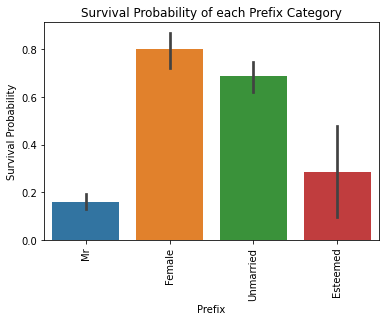

In [ ]:
#Barplot of percentage of people survived in each Prefix Category
g = sns.barplot(x="Prefix",y="Survived",data=df_train_cleaned)
# g = g.set_xticklabels(["Mr","Female","Unmarried","Esteemed"])
plt.xticks(rotation = 90)
plt.ylabel("Survival Probability")
plt.title("Survival Probability of each Prefix Category");

In [ ]:
df_train_cleaned['Prefix'].value_counts()

Mr           513
Unmarried    217
Female       130
Esteemed      21
Name: Prefix, dtype: int64

From the above plot, we see that passengers with prefix categorized as "Female" has the highest survival rate, followedd by "Unmarried", "Esteemed". "Mr", which consisted of majority of males, has the lowest survival rate. Therefore we see that there is a relationship between different categories of prefix and survival rate.

In [ ]:
#Change Prefix into dummy variables to be included in modeling and drop the 'Name' column as only prefix will be used to train our model.
df_train_cleaned = pd.get_dummies(df_train_cleaned, columns=['Prefix'])
# df_train_cleaned = df_train_cleaned.drop(labels=['Name'], axis=1)
df_train_cleaned.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,No Cabin,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,No Cabin,S,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,No Cabin,S,0,0,1,0


In [ ]:
#Unique values in prefix of test set
df_test_cleaned['Prefix'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [ ]:
#Categorize for test set, create dummy variables for prefix in the test set and drop 'Name' Column for test set.
df_test_cleaned["Prefix"] = df_test_cleaned["Prefix"].replace(['Ms', 'Mrs', 'Dona'], 'Female')
df_test_cleaned["Prefix"] = df_test_cleaned["Prefix"].replace(['Master', 'Miss'], 'Unmarried')
df_test_cleaned["Prefix"] = df_test_cleaned["Prefix"].replace(['Dr', 'Rev', 'Col'], 'Esteemed')
df_test_cleaned = pd.get_dummies(df_test_cleaned, columns=['Prefix'])
# df_test_cleaned = df_test_cleaned.drop(labels=['Name'], axis=1)
df_test_cleaned.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,No Cabin,Q,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,No Cabin,S,0,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,No Cabin,Q,0,0,1,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,No Cabin,S,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,No Cabin,S,0,1,0,0


#### **2.c Relationshiop with Survived: Pclass**

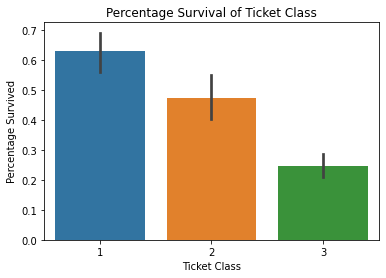

In [ ]:
#Percentage of people survived in each ticket class
sns.barplot(x='Pclass', y = 'Survived', data = df_train_cleaned)
plt.title("Percentage Survival of Ticket Class")
plt.xlabel("Ticket Class")
plt.ylabel("Percentage Survived");

From the above plot, we see that ticket class 1 has the highest survival rate, followed by ticket class 2 and 3. Therefore, there is a clear relationship between ticket class and survival rate.

In [ ]:
# #Add dummy variables for class categories in the train set
# df_train_cleaned['Low_class'] = df_train['Pclass'].map(lambda s: 1 if s == 3 else 0)
# df_train_cleaned['Medium_class'] = df_train['Pclass'].map(lambda s: 1 if s== 2  else 0)
# df_train_cleaned['High_class'] = df_train['Pclass'].map(lambda s: 1 if s == 1 else 0)

In [ ]:
# #Add dummy variables for class categories in the test set
# df_test_cleaned['Low_class'] = df_test_cleaned['Pclass'].map(lambda s: 1 if s == 3 else 0)
# df_test_cleaned['Medium_class'] = df_test_cleaned['Pclass'].map(lambda s: 1 if s== 2  else 0)
# df_test_cleaned['High_class'] = df_test_cleaned['Pclass'].map(lambda s: 1 if s == 1 else 0)

#### **2.d Relationship with Survived: Fare**


We can see that ticket class 1 has more higher priced fare as expected.

In [ ]:
#stats of fare
df_train_cleaned['Fare'].describe()

count    881.000000
mean      31.121566
std       47.996249
min        0.000000
25%        7.895800
50%       14.454200
75%       30.500000
max      512.329200
Name: Fare, dtype: float64

In [ ]:
#stats of survived people's fare
df_train_cleaned[df_train_cleaned['Survived'] == 1]['Fare'].describe()

count    340.000000
mean      47.133028
std       64.714885
min        0.000000
25%       12.443750
50%       26.000000
75%       56.946900
max      512.329200
Name: Fare, dtype: float64

In [ ]:
#stats of not survived people's fare
df_train_cleaned[df_train_cleaned['Survived'] == 0]['Fare'].describe()

count    541.000000
mean      21.058909
std       29.361122
min        0.000000
25%        7.854200
50%       10.462500
75%       26.000000
max      263.000000
Name: Fare, dtype: float64

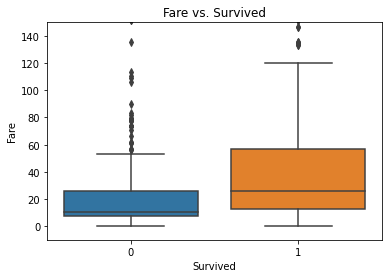

In [ ]:
#boxplot of fare vs. survived
sns.boxplot(data=df_train_cleaned, x='Survived', y='Fare').set_ylim([-10, 150])
plt.title('Fare vs. Survived');

We can see that the interquartile range of survived people's fare is larger, and the median of survived people's fare is higher as well. From the above analysis, we see that fare shows differences between survived and those that did not, and therefore we will use fare as a feature to fit our model.

Since some models may prefer smaller or normalized numbers, we will add a column for z scores of fare for future use. We wanted to add log of fare, but some fares are 0 which gives infinitive log values.

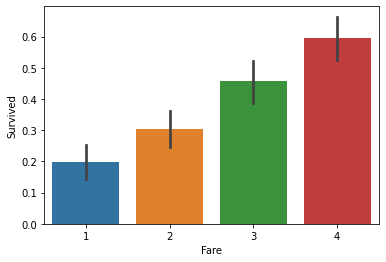

In [ ]:
# df_train_cleaned.loc[(df_train_cleaned['Fare'].str.isnumeric()) & (df_train_cleaned['Fare'] <= 26), 'Fare'] = 'cheap'
# df_train_cleaned.loc[(df_train_cleaned['Fare'].str.isnumeric()) & (26 < df_train_cleaned['Fare'] <= 100), 'Fare'] = 'normal'
# df_train_cleaned.loc[(df_train_cleaned['Fare'].str.isnumeric()) & (100 < df_train_cleaned['Fare'] <= 200), 'Fare'] = 'expensive'
# df_train_cleaned.loc[(df_train_cleaned['Fare'].str.isnumeric()) &  (df_train_cleaned['Fare'] > 200), 'Fare'] = 'super'
bins = [0, 26, 100, 200, np.inf]
labels = [1, 2, 3, 4]
# pd.qcut(df_train_cleaned['Fare'], 4)
# sns.barplot(x=pd.cut(x = df_train_cleaned['Fare'], bins = bins, labels=labels), y=df_train_cleaned['Survived'])
sns.barplot(x = df_train_cleaned['Fare'], y=df_train_cleaned['Survived'])

In [ ]:
df_train_cleaned['Fare'] = pd.qcut(df_train_cleaned['Fare'], 4, labels=labels)

ValueError: ignored

In [ ]:
#add column for z score of fare
# df_train_cleaned["fare z-score"] = (df_train_cleaned['Fare'] - np.mean(df_train_cleaned['Fare']))/np.std(df_train_cleaned['Fare'])
# df_test_cleaned["fare z-score"] = (df_test_cleaned['Fare'] - np.mean(df_test_cleaned['Fare']))/np.std(df_test_cleaned['Fare'])
df_train_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1,No Cabin,S,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4,C85,C,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2,No Cabin,S,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,4,C123,S,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2,No Cabin,S,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,2,No Cabin,S,1,0,0,0
877,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,3,B42,S,0,0,0,1
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,3,No Cabin,S,0,0,0,1
879,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,3,C148,C,0,0,1,0


In [ ]:
# df_test_cleaned['Fare_Cheap'] = df_test_cleaned['Fare'].map(lambda s: 1 if s <= 26 else 0)
# df_test_cleaned['Fare_Normal'] = df_test_cleaned['Fare'].map(lambda s: 1 if  26 < s <= 100  else 0)
# df_test_cleaned['Fare_Expensive'] = df_test_cleaned['Fare'].map(lambda s: 1 if 100 < s <= 200 else 0)
# df_test_cleaned['Fare_Super'] = df_test_cleaned['Fare'].map(lambda s: 1 if s > 200 else 0)
df_test_cleaned['Fare'] = pd.qcut(df_test_cleaned['Fare'], 4, labels=labels)
df_test_cleaned

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,1,No Cabin,Q,0,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1,No Cabin,S,0,1,0,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2,No Cabin,Q,0,0,1,0
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2,No Cabin,S,0,0,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2,No Cabin,S,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,2,No Cabin,S,0,0,1,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,4,C105,C,0,1,0,0
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,1,No Cabin,S,0,0,1,0
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,2,No Cabin,S,0,0,1,0


#### **2.e Relationship with Survived: Ticket Number**

We noticed that some ticket numbers have prefix and would like to see what relationship ticket prefix may have with survived.

In [ ]:
#Separate ticket prefix into its own column 'Ticket Prefix'
tic_prefix = []
for i in df_train_cleaned['Ticket']:
    if not i.isdigit():
        tic = i.replace("/","").replace(".","").strip().split(' ')
        tic_prefix.append(tic[0])
    else:
        tic_prefix.append("No Prefix")
        
df_train_cleaned['Ticket Prefix'] = tic_prefix

In [ ]:
df_train_cleaned = df_train_cleaned.drop('Ticket Prefix', axis = 1)

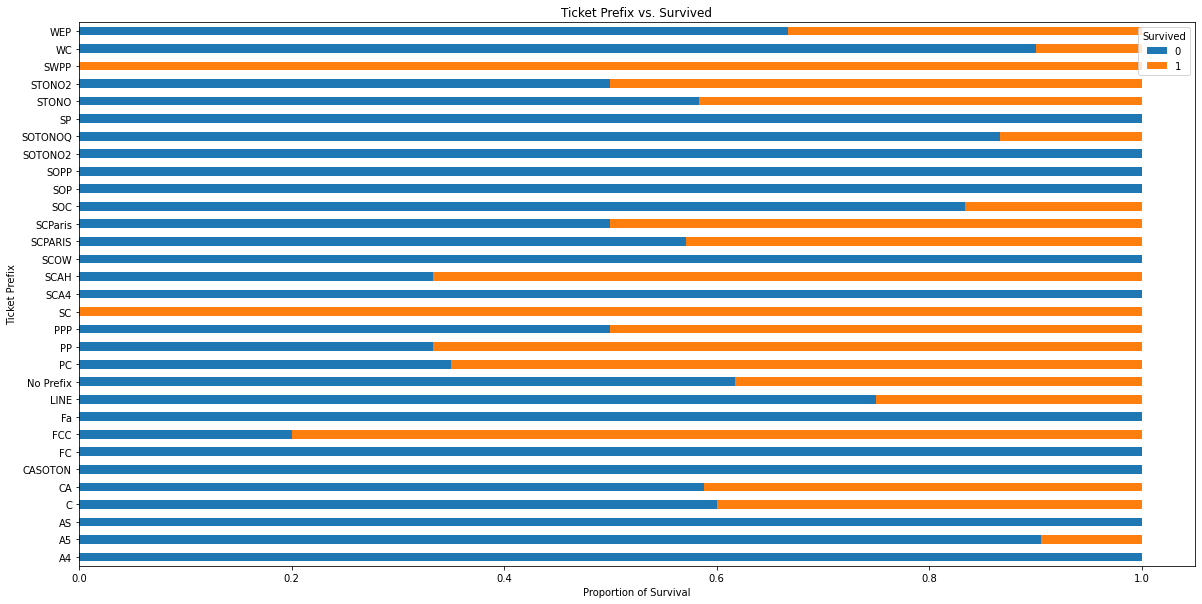

In [ ]:
#Plot proportion of survived(1) vs. not survived(0) of each ticket prefix
st = pd.crosstab(df_train_cleaned['Ticket Prefix'],df_train_cleaned['Survived']).apply(lambda r: r/r.sum(), axis=1)
st.plot.barh(stacked=True, figsize=(20,10))
plt.xlabel("Proportion of Survival")
plt.ylabel('Ticket Prefix')
plt.title("Ticket Prefix vs. Survived");

From the above plot, we see that all passengers with ticket starting with SWPP and SC survived. All passengers with ticket starting with SP, SOTONO2, SOPP, SOP, Fa, AS and A4 did not survive.
There is a clear indication that survival rate of different ticket prefix differs. Therefore we will include dummy variables of ticket prefix into fitting our models.

In [ ]:
# #add dummy variables of ticket prefix to training set
# train_dummy = pd.get_dummies(data=df_train_cleaned['Ticket Prefix'])
# df_train_cleaned = df_train_cleaned.join(train_dummy)

In [ ]:
#add dummy variables of ticket prefix to training set
# df_train_cleaned = pd.get_dummies(df_train_cleaned, columns=['Ticket Prefix'])
# # df_train_cleaned.drop(labels=['Ticket Prefex_STONO2', 'Ticket Prefex_STONO', 'Ticket Prefex_SCParis', 'Ticket Prefex_SCPARIS', 'Ticket Prefex_PPP'], axis=1)
# df_train_cleaned

Repeating the same procedure for test set below.

In [ ]:
# #Separate ticket prefix for test set
# tic_prefix_test = []
# for i in df_test_cleaned['Ticket']:
#     if not i.isdigit():
#         tic = i.replace("/","").replace(".","").strip().split(' ')
#         tic_prefix_test.append(tic[0])
#     else:
#         tic_prefix_test.append("No Prefix")
        
# df_test_cleaned['Ticket Prefix'] = tic_prefix_test

In [ ]:
# #add dummy variables of ticket prefix to training set
# test_dummy = pd.get_dummies(data=df_test_cleaned['Ticket Prefix'])
# df_test_cleaned = df_test_cleaned.join(test_dummy)

By checking shape of clceaned train and test set so far, we see that number of columns do not match because values of ticket prefix differ in train and test set. We will examine what values are missing in each set and if those values are worth keeping.

In [ ]:
#unique values in ticket prefix of train and test set
# train_prefix_val = df_train_cleaned['Ticket Prefix'].unique()
# test_prefix_val = df_test_cleaned['Ticket Prefix'].unique()

In [ ]:
#ticket prefix values missing in test set
# missing_val_train = np.array([])
# for i in train_prefix_val:
#   if i not in test_prefix_val:
#     missing_val_train = np.append(missing_val_train, i)
# missing_val_train

array(['SP', 'SOP', 'Fa', 'LINE', 'SWPP', 'SCOW', 'PPP', 'AS', 'CASOTON'],
      dtype='<U32')

In [ ]:
# df_train_cleaned['Ticket Prefix'].value_counts()

No Prefix    658
PC            60
CA            34
A5            21
SOTONOQ       15
STONO         12
WC            10
A4             7
SCPARIS        7
STONO2         6
SOC            6
C              5
FCC            5
LINE           4
SCParis        4
SCAH           3
SOPP           3
PP             3
WEP            3
SWPP           2
PPP            2
SOTONO2        2
FC             1
SC             1
CASOTON        1
Fa             1
SP             1
SOP            1
SCOW           1
SCA4           1
AS             1
Name: Ticket Prefix, dtype: int64

Each of the prefix values in the training set that do not exist in the test set has 4 values or less. Since it is a small amount of data, we will go ahead and remove these columns in the training set.

In [ ]:
#remove prefix that do not exist in test set from the trainig set
# df_train_cleaned = df_train_cleaned.drop(labels=missing_val_train, axis=1)
# df_train_cleaned.shape

(881, 43)

Now checking test set ticket prefix values that do not exist in the training set.

In [ ]:
#ticket prefix values missing in train set
# missing_val_test = np.array([])
# for i in test_prefix_val:
#   if i not in train_prefix_val:
#     missing_val_test = np.append(missing_val_test, i)
# missing_val_test

array(['SCA3', 'STONOQ', 'AQ4', 'A', 'LP', 'AQ3'], dtype='<U32')

In [ ]:
# df_test_cleaned['Ticket Prefix'].value_counts()

No Prefix    296
PC            32
CA            27
SOTONOQ        9
SCPARIS        7
A5             7
WC             5
FCC            4
SOPP           4
A4             3
C              3
FC             2
SOC            2
STONO          2
SCAH           2
AQ3            1
A              1
WEP            1
SCA3           1
STONO2         1
SCParis        1
LP             1
AQ4            1
PP             1
SOTONO2        1
SCA4           1
SC             1
STONOQ         1
Name: Ticket Prefix, dtype: int64

For the same reasons, we will remove  values that do not exist in training set from the test set.

In [ ]:
# df_test_cleaned = df_test_cleaned.drop(labels=missing_val_test, axis=1)
# df_test_cleaned.shape

(418, 42)

In [ ]:
# df_test_cleaned = pd.get_dummies(df_test_cleaned, columns=['Ticket Prefix'], dummy_na=False)
# # df_test_cleaned.drop(labels=['Ticket Prefex_STONO2', 'Ticket Prefex_STONO', 'Ticket Prefex_SCParis', 'Ticket Prefex_SCPARIS'], axis=1)
# df_test_cleaned

#### **2.f Relationship with Survived: Embarked**

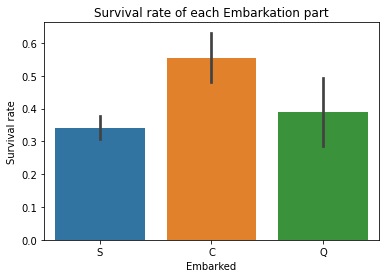

In [ ]:
#Plot percentage survivied in each part of embarkation
sns.barplot(x="Embarked",y="Survived",data = df_train_cleaned)
plt.title("Survival rate of each Embarkation part")
plt.ylabel("Survival rate");

We see differences in suvival rate between different parts of embarkation. We will transform Embarked into dummy variables and use them in model training.

In [ ]:
#add embarked dummies to train
df_train_cleaned = pd.get_dummies(df_train_cleaned, columns = ["Embarked"])

In [ ]:
#add embarked dummies to test
df_test_cleaned = pd.get_dummies(df_test_cleaned, columns = ["Embarked"])

#### **2.g Relationship with Survived: Cabin**

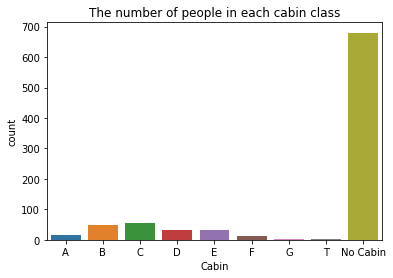

In [ ]:
#plot number of people in each cabin class based of first letter of cabin class
df_train_cleaned['Cabin'] = df_train_cleaned['Cabin'].apply(lambda x: x if x == 'No Cabin' else x[0])
sns.countplot(x = df_train_cleaned['Cabin'], data = df_train_cleaned, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'No Cabin'])
plt.title('The number of people in each cabin class')
plt.show()

From the above plot, we see the differences between number of people in each cabin class. Majority of people have no cabin, only a small amount of passengers had a cabin number.

In [ ]:
#change cabin column of test set to only the first letter of each cabin class
df_test_cleaned['Cabin'] = df_test_cleaned['Cabin'].apply(lambda x: x if x == 'No Cabin' else x[0])

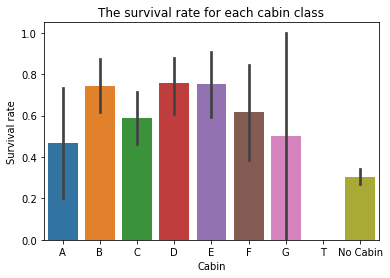

In [ ]:
#plot the survival rate of each cabin class in the train set
sns.barplot(x='Cabin', y="Survived", data=df_train_cleaned, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'No Cabin'])
plt.ylabel("Survival rate")
plt.title('The survival rate for each cabin class');

We see differences in survival rate of each cabin, and we will include dummy variables of cabin into training our models.

In [ ]:
#unique cabin values in train set
df_train_cleaned['Cabin'].unique()

array(['No Cabin', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [ ]:
df_train_cleaned['Cabin'].value_counts()

No Cabin    680
C            56
B            47
D            33
E            32
A            15
F            13
G             4
T             1
Name: Cabin, dtype: int64

In [ ]:
#unique cabin values in test set
df_test_cleaned['Cabin'].unique()

array(['No Cabin', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

Since Cabin 'T' does not exists in the test set, and only there is only one passenger with cabin 'T' in the test set, we will not include the dummy variable for cabin 'T' in the final data.

In [ ]:
#Create dummy variables for cabin column in train set
df_train_cleaned = pd.get_dummies(data=df_train_cleaned, columns=['Cabin']).drop(labels=['Cabin_T'], axis=1)

In [ ]:
#Create dummy variables for cabin column in test set
df_test_cleaned = pd.get_dummies(data=df_test_cleaned, columns=['Cabin'])

#### **2.h Relationship with Survived: Famsize**

Since both "SibSp" and "Parch" give information about how many family members the passenger have on board, we would like to combine them into one feature called "Famsize", with Famesize = SibSp + Parch + 1(for passenger him/herself).

In [ ]:
#add famsize for train set
df_train_cleaned["Famsize"] = df_train_cleaned["SibSp"] + df_train_cleaned["Parch"] + 1

In [ ]:
#add famsize for test set
df_test_cleaned['Famsize'] = df_test_cleaned['SibSp'] + df_test_cleaned["Parch"] + 1

In [ ]:
#stats of famsize of train set
df_train_cleaned['Famsize'].describe()

count    881.000000
mean       1.818388
std        1.382086
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        8.000000
Name: Famsize, dtype: float64

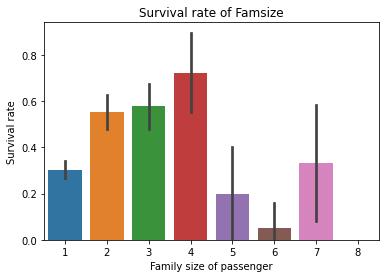

In [ ]:
#barplot of survival rate of each fam size
sns.barplot(x='Famsize', y = 'Survived', data = df_train_cleaned)
plt.title("Survival rate of Famsize")
plt.xlabel("Family size of passenger")
plt.ylabel("Survival rate");

We see that survival rate of differnt family size of passenger differs, and therefore we will include family size into training our model. To do so, we categorized family size into single, small, medium and large fams based on how many family members are on board as below.

In [ ]:
#Categorize famsize and add dummy variables for each category for test set
# df_train_cleaned['Single_Fam'] = df_train_cleaned['Famsize'].map(lambda s: 1 if s == 1 else 0)
# df_train_cleaned['Small_Fam'] = df_train_cleaned['Famsize'].map(lambda s: 1 if 2<=s <=3  else 0)
# df_train_cleaned['Medium_Fam'] = df_train_cleaned['Famsize'].map(lambda s: 1 if s ==4  else 0)
# df_train_cleaned['Large_Fam'] = df_train_cleaned['Famsize'].map(lambda s: 1 if s >4  else 0)
df_train_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_No Cabin,Famsize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,4,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
877,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,3,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,W./C. 6607,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,4
879,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
#Categorize famsize and add dummy variables for each category for train set
# df_test_cleaned['Single_Fam'] = df_test_cleaned['Famsize'].map(lambda s: 1 if s == 1 else 0)
# df_test_cleaned['Small_Fam'] = df_test_cleaned['Famsize'].map(lambda s: 1 if 2<=s <=3  else 0)
# df_test_cleaned['Medium_Fam'] = df_test_cleaned['Famsize'].map(lambda s: 1 if s ==4  else 0)
# df_test_cleaned['Large_Fam'] = df_test_cleaned['Famsize'].map(lambda s: 1 if s >4  else 0)
df_test_cleaned

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_No Cabin,Famsize
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,4,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1


#### **2.i Fill in values for Age**

In order to determine which features to use for predicting age values, we look at correlations of each feature with age.

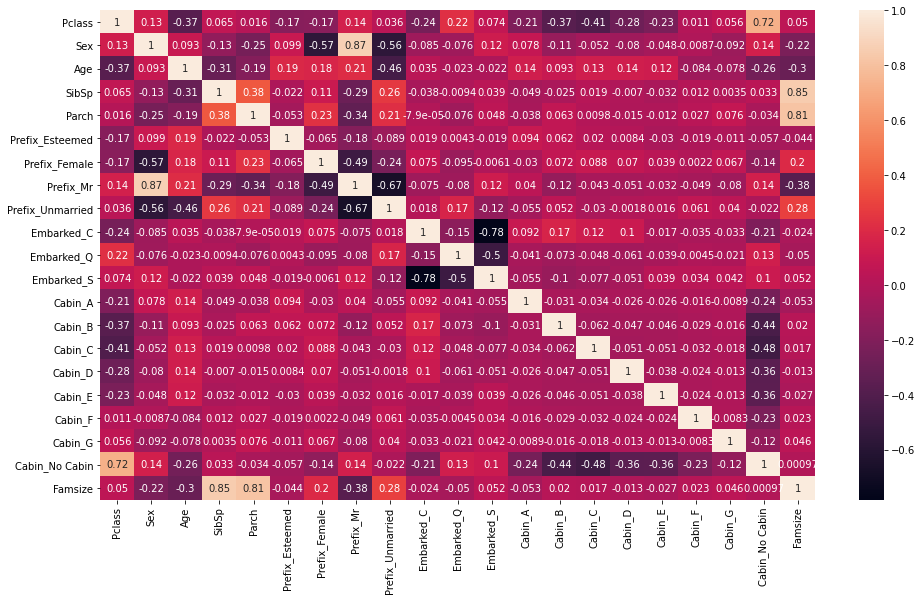

In [ ]:
#Create a heatmap to examine existing features correlated with "Age"
plt.figure(figsize = (16, 9))
Var_Corr = df_train_cleaned.drop(labels=['PassengerId', 'Survived', 'Name'], axis=1).corr()
Var_Corr
sns.heatmap(data=Var_Corr, annot=True);

We selected features with the highest correlation index: Pclass, High_class, Prefix_Unmarried. We will fill in the missing age values with median of age values of passengers that have the save pclass, high_class and prefix_unmarried values.

In [ ]:
#Fill in the missing value in the "Age" column in the train set. 
missing_idx = df_train_cleaned['Age'][df_train_cleaned['Age'].isnull()].index
for x in missing_idx:
  temp = df_train_cleaned.loc[x]
  df_temp = df_train_cleaned[(df_train_cleaned['Pclass'] == temp['Pclass']) & (df_train_cleaned['SibSp'] == temp['SibSp']) 
                        & (df_train_cleaned['Prefix_Unmarried'] == temp['Prefix_Unmarried'])] 
  impute_age = df_temp['Age'].median()
  df_train_cleaned.loc[x, 'Age'] = impute_age

In [ ]:
#checking number of null values left in age
df_train_cleaned['Age'].isnull().sum()

0

In [ ]:
#Using the same method to fill in the missing value in the "Age" column in the test set. 
missing_idx = df_test_cleaned['Age'][df_test_cleaned['Age'].isnull()].index
for x in missing_idx:
  temp = df_test_cleaned.loc[x]
  df_temp = df_test_cleaned[(df_test_cleaned['Pclass'] == temp['Pclass']) & (df_test_cleaned['SibSp'] == temp['SibSp']) 
                        & (df_test_cleaned['Prefix_Unmarried'] == temp['Prefix_Unmarried'])] 
  impute_age = df_temp['Age'].median()
  df_test_cleaned.loc[x, 'Age'] = impute_age

In [ ]:
df_test_cleaned['Age'].isnull().sum()

0

In [ ]:
#Normalize the 'Age' column. 
scaler = StandardScaler() 
age_scaled_train = scaler.fit_transform(df_train_cleaned[['Age']].values)
df_train_cleaned['Age'] = pd.DataFrame(age_scaled_train)
age_scaled_test = scaler.fit_transform(df_test_cleaned[['Age']].values)
df_test_cleaned['Age'] = pd.DataFrame(age_scaled_test)

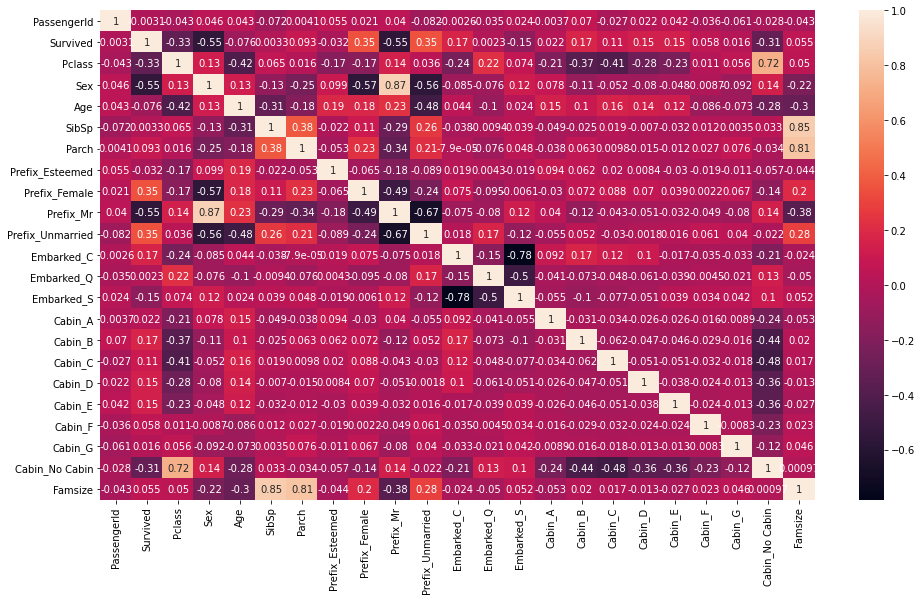

In [ ]:
plt.figure(figsize = (16, 9))
corr = df_train_cleaned.corr()
sns.heatmap(data=corr, annot=True)

In [ ]:
#check number of column/row matches/is correct
df_train_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_No Cabin,Famsize
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,4,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,211536,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1
877,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,3,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,10.5,1,2,W./C. 6607,3,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,4
879,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,111369,3,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
df_test_cleaned

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_No Cabin,Famsize
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,2
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,26.0,0,0,A.5. 3236,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,4,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1
416,1308,3,"Ware, Mr. Frederick",1,26.0,0,0,359309,2,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1


### **Step 3: Model Training**

---



#### **3.a Model Selection & Ensemble**

We will first select the features we want for model fitting.

In [ ]:
#Extract the target label. 
Y_train = df_train_cleaned['Survived']
X_train = df_train_cleaned.drop(['Survived', 'PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Prefix_Mr'], axis = 1)
X_test = df_test_cleaned.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Prefix_Mr'], axis = 1)

In [ ]:
X_train['Fare'] = X_train['Fare'].astype('int64')
X_test['Fare'] = X_test['Fare'].astype('int64')

We will plot the cross validation score for different classification models predicting on the training set.

<BarContainer object of 12 artists>

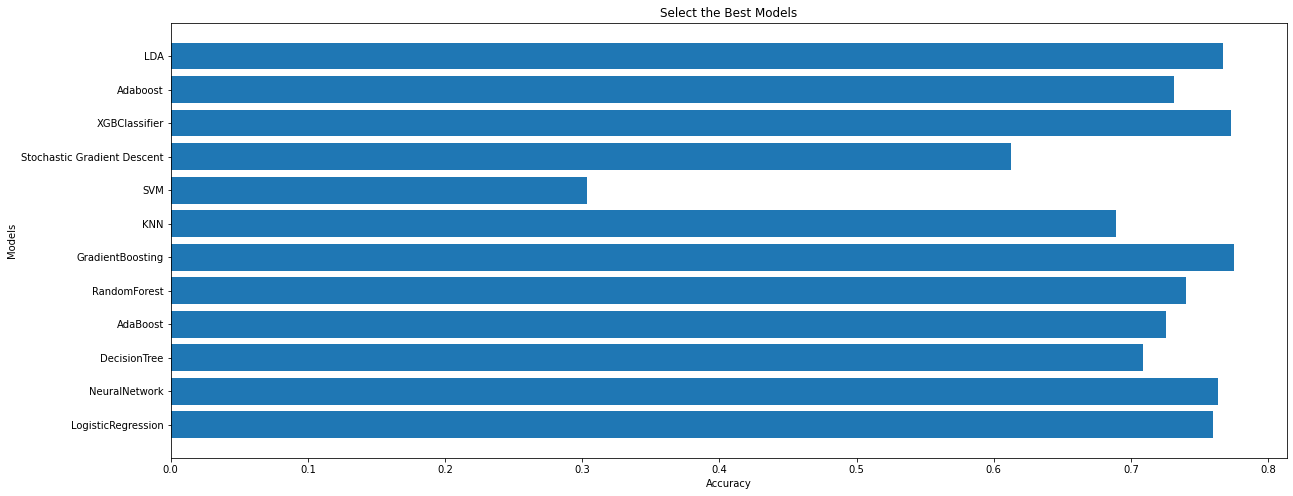

In [ ]:
#Select the best models 
random_state = 33
clfs = []
clfs.append(LogisticRegression(random_state = random_state))
clfs.append(MLPClassifier(random_state=random_state))
clfs.append(DecisionTreeClassifier(random_state=random_state))
clfs.append(AdaBoostClassifier(random_state=random_state,learning_rate=0.1))
clfs.append(RandomForestClassifier(random_state=random_state))
clfs.append(GradientBoostingClassifier(random_state=random_state))
clfs.append(KNeighborsClassifier())
clfs.append(SVC(random_state=random_state))
clfs.append(SGDClassifier('log', random_state=random_state, shuffle=True))
clfs.append(XGBClassifier(random_state=random_state))
clfs.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
clfs.append(LinearDiscriminantAnalysis())
results = []
for clf in clfs :
    results.append(cross_val_score(clf, X_train, Y_train, scoring = "f1", cv = 5, n_jobs=-1))

cv = [x.mean() for x in results]
clf_name = ["LogisticRegression","NeuralNetwork", "DecisionTree","AdaBoost", "RandomForest","GradientBoosting","KNN", "SVM", 'Stochastic Gradient Descent', 'XGBClassifier',  'Adaboost', 'LDA']
plt.figure(figsize=(20, 8))
plt.ylabel('Models')
plt.xlabel('Accuracy')
plt.title('Select the Best Models')

plt.barh(clf_name, cv)

From the above plot, we see that Logistic Regression, Support Vector Classification, Optimized Gradiant Boosting Classifier, Gradient Boosting Classifier, Random Forest, Neural Network and K nearest neighbors gives the best cross validation scores. We will go ahead and tune these models' hyperparameters.

In [ ]:
#Hyperparameter Tuning - Logistic Regression
log_reg = LogisticRegression(random_state=42, n_jobs=-1)
param_space = {
    'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
gsLR = GridSearchCV(log_reg, param_grid=param_space, cv = 5, verbose=1, scoring='f1', n_jobs=-1)
gsLR.fit(X_train, Y_train)
gsLR_best = gsLR.best_estimator_
gsLR.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1539: UserWarning:

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.



0.7745178803786962

In [ ]:
#Hyperparameter Tuning - SVM
svm = SVC(probability=True)
svm.fit(X_train, Y_train)
param_space = {
    'kernel': ['rbf'], 
    'gamma': [ 0.001, 0.01, 0.1, 1],
    'C': [1, 10, 50, 100,200,300, 1000]
}
gsSVM = GridSearchCV(svm, param_grid=param_space, cv = 5, verbose=1, scoring='f1', n_jobs=-1)
gsSVM.fit(X_train, Y_train)
gsSVM_best = gsSVM.best_estimator_
gsSVM.best_score_

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   24.0s finished


0.7755224021975942

In [ ]:
#Hyperparameter Tuning - XGBoosting

xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
param_space = {
     
    'n_estimators': [2500],
    'max_depth': [7],
    'gamma': [1.5],
    'min_child_weight': [5],
    'subsample': [0.8]
}
gsXGB = GridSearchCV(xgb, param_grid=param_space, cv = 5, verbose=1, scoring='f1', n_jobs=-1)
gsXGB.fit(X_train, Y_train)
gsXGB_best = gsXGB.best_estimator_
gsXGB.best_score_
# xgb = XGBClassifier(learning_rate=0.001,n_estimators=2500,
#                                 max_depth=4, min_child_weight=0,
#                                 gamma=0, subsample=0.7,
#                                 colsample_bytree=0.7,
#                                 scale_pos_weight=1, seed=27,
#                                 reg_alpha=0.00006)
# xgb.fit(X_train, Y_train)
# Y_pred = xgb.predict(X_train)
# accuracy_score(Y_train, Y_pred)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


0.793678921225808

In [ ]:
gsXGB.best_params_

{'colsample_bytree': 1.0,
 'gamma': 1.5,
 'max_depth': 7,
 'min_child_weight': 5,
 'n_estimators': 2500,
 'subsample': 0.8}

In [ ]:
#Hyperparameter Tuning - Gradient Boosting Classifier
GB = GradientBoostingClassifier(random_state=42)
param_space = {
    "learning_rate": [0.2, 0.205],
    "n_estimators":[120, 110, 105]
}
gsGB = GridSearchCV(GB, param_grid=param_space, cv = 5, verbose=1, scoring='f1', n_jobs=-1)
gsGB.fit(X_train, Y_train)
gsGB_best = gsGB.best_estimator_
gsGB.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.1s finished


0.7788057477170379

In [ ]:
gsGB.best_params_

{'learning_rate': 0.2, 'n_estimators': 120}

In [ ]:
#Hyperparameter Tuning - Random Forest
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {'bootstrap': [False],
    'max_depth': [None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2, 3],
    'n_estimators': [400, 600, 500]}

gsRFC = GridSearchCV(rf,param_grid = rf_param_grid, cv=5, scoring="f1", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.6min finished


0.7743941248470012

In [ ]:
gsRFC.best_estimator_.feature_importances_

array([0.11205899, 0.29915362, 0.09913678, 0.05901514, 0.00108019,
       0.11037924, 0.13666307, 0.0099979 , 0.00468854, 0.012644  ,
       0.00069718, 0.00813469, 0.00324349, 0.00521776, 0.00739079,
       0.00060423, 0.        , 0.05750122, 0.07239315])

In [ ]:
# #Hyperparameter Tuning - KNN
# knn = KNeighborsClassifier()
# param_space = {
#     'n_neighbors' : np.arange(1, 31)
# }
# gsKNN = GridSearchCV(knn, param_grid=param_space, cv = 5, verbose=1, scoring='accuracy', n_jobs=-1)
# gsKNN.fit(X_train, Y_train)
# gsKNN_best = gsLR.best_estimator_
# gsKNN.best_score_

In [ ]:
# #Hyperparameter Tuning - Neural Network
# mlp = MLPClassifier(random_state=42)

# param_space = {
#     'hidden_layer_sizes': [(30,30), (30, 50), (10, 10)],
#     'activation': ['logistic', 'relu'],
#     'solver': ['sgd', 'lbfgs'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# gsMLP = GridSearchCV(mlp, param_grid=param_space, cv = 5, verbose=1, scoring='accuracy', n_jobs=-1)
# gsMLP.fit(X_train, Y_train)
# gsMLP_best = gsMLP.best_estimator_
# gsMLP.best_score_

We will use soft voting rule classifier to ensemble the best models and use it to predict X_test once.

In [ ]:
#Each estimator casts vote
vote_clf = VotingClassifier(estimators=[('lr', gsLR_best), ('rf', RFC_best), ('gb', gsGB_best), ('svm', gsSVM_best)], voting='soft', n_jobs=-1)
vote_clf.fit(X_train, Y_train)
Y_pred = vote_clf.predict(X_test)
Y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

#### **3.b Feature Selection**

Now that we have the best model, we will examine if fitting different features give different results, and if one combination of features would optimize the result of our model.

In order to assess our models, we will plot the root mean squared error $RMSE$ of each model with different features predicting on the training set. In addition, we plot the cross validation root mean squared error $CV RMSE$ of the models as well. Last but not least, we will show coefficient of determination, $R^2$ value of the given model to explain how much variances are explained by the given model.

In [ ]:
# Function to compute rmse
def Rmse(Y, Y_Predicted):
    return np.sqrt(np.mean((Y - Y_Predicted)**2))

In [ ]:
# Function to compute cross validation rmse
def CV_Rmse(Model, Train, Y, NFold = 5):
    Model = clone(Model)
    N_Fold = KFold(n_splits= NFold)
    Rmse_Val = []
    for Train_Idx, Val_Idx in N_Fold.split(Train):
        Model.fit(Train.iloc[Train_Idx,:], Y.iloc[Train_Idx])
        Rmse_Val.append(Rmse(Y.iloc[Val_Idx], Model.predict(Train.iloc[Val_Idx,:])))
    return np.mean(Rmse_Val)

In [ ]:
# A dictionary to record our state models
Feature_Ensemble_Models = {}

# Build the pipeline
def Assess(Train, X_Columns, Y, Model_Abrv, Model_List, CV_NFold):
  Model = Pipeline([
                    ("PickColumns", ColumnTransformer([("keep", "passthrough", X_Columns)])),
                    # ("Scale", StandardScaler()), 
                    ("EnsembleModel", VotingClassifier(estimators=[('lr', gsLR_best), ('rf', RFC_best), ('xgb', xgb), ('gb', gsGB_best), ('svm', gsSVM_best)], voting='soft', n_jobs=-1))
                    ])
  Model.fit(Train, Y)
  Y_Predicted = Model.predict(Train)
  # Return the rmse of the given model predicting on traning set
  print("Training Error (RMSE): ", Rmse(Y, Y_Predicted))
  # Return the cross validation rmse of the given model predicting on traning set
  print("Cross Validation Error : ", CV_Rmse(Model, Train, Y, CV_NFold))
  # Return the R^2 value of the given model predicting on traning set
  print("R Square Training: ", Model.score(Train, Y))
  # Save the model to list of models
  Feature_Ensemble_Models[Model_Abrv] = Model

We use SelecKBest features to select the amount of best features we want. We will make selected amount of features into its own model, add them to Feature_Ensemble_Models dictionary, asses their performances and plot their performances in the end.


In [ ]:
#10 best features
bestfeatures = SelectKBest(k=10)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_10 = df_scores.nlargest(10, 'Score')
best_10_label = np.array(best_10['Feature']).astype(str)
Assess(X_train, best_10_label, Y_train, 'best10', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.4070881622574774
Cross Validation Error :  0.41932521102140674
R Square Training:  0.8342792281498297


In [ ]:
#15 best features
bestfeatures = SelectKBest(k=15)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_15 = df_scores.nlargest(15, 'Score')
best_15_label = np.array(best_15['Feature']).astype(str)
Assess(X_train, best_15_label, Y_train, 'best15', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.40005674966333443
Cross Validation Error :  0.41963203495985546
R Square Training:  0.8399545970488081


In [ ]:
#20 best features
bestfeatures = SelectKBest(k=20)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_20 = df_scores.nlargest(20, 'Score')
best_20_label = np.array(best_20['Feature']).astype(str)
Assess(X_train, best_20_label, Y_train, 'best20', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3986355844269251
Cross Validation Error :  0.41171707276216674
R Square Training:  0.8410896708286039


In [ ]:
#25 best features
bestfeatures = SelectKBest(k=25)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_25 = df_scores.nlargest(25, 'Score')
best_25_label = np.array(best_25['Feature']).astype(str)
Assess(X_train, best_25_label, Y_train, 'best25', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3943413595249794
Cross Validation Error :  0.4130393265983665
R Square Training:  0.8444948921679909


In [ ]:
#30 best features
bestfeatures = SelectKBest(k=30)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_30 = df_scores.nlargest(30, 'Score')
best_30_label = np.array(best_30['Feature']).astype(str)
Assess(X_train, best_30_label, Y_train, 'best30', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3943413595249794
Cross Validation Error :  0.41157913529189083
R Square Training:  0.8444948921679909


In [ ]:
#35 best features
bestfeatures = SelectKBest(k=35)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_35 = df_scores.nlargest(35, 'Score')
best_35_label = np.array(best_35['Feature']).astype(str)
Assess(X_train, best_35_label, Y_train, 'best35', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3957779448274054
Cross Validation Error :  0.41157913529189083
R Square Training:  0.8433598183881952


In [ ]:
#40 best features
bestfeatures = SelectKBest(k=40)
select = bestfeatures.fit(X_train,Y_train)
df_scores = pd.DataFrame(select.scores_)
df_columns = pd.DataFrame(X_train.columns)
df_scores = pd.concat([df_scores, df_columns], axis=1)
df_scores.columns = ['Score', 'Feature']
best_40 = df_scores.nlargest(40, 'Score')
best_40_label = np.array(best_40['Feature']).astype(str)
Assess(X_train, best_40_label, Y_train, 'best40', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3943413595249794
Cross Validation Error :  0.4114843125588889
R Square Training:  0.8444948921679909


In [ ]:
#all features
all_label = np.array(X_train.columns).astype(str)
Assess(X_train, all_label, Y_train, 'all', Feature_Ensemble_Models, 5)

Training Error (RMSE):  0.3943413595249794
Cross Validation Error :  0.41430447147011107
R Square Training:  0.8444948921679909


In [ ]:
# Model Comparing Function
def Compare_M(Models, Train, Y, CV_N):
    # Compute the training rmse for each model
    Train_Rmse = [Rmse(Y, m.predict(Train)) for m in Models.values()]
    # Compute the cross validation error for each model
    Validation_Rmse = [CV_Rmse(m, Train, Y, CV_N) for m in Models.values()]
    # Compute the R Square for each model
    R_Square = [m.score(Train, Y) for m in Models.values()]

    labs = list(Models.keys())
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(x = labs, y = Train_Rmse, name="Training RMSE"),
        secondary_y = False
        )
    fig.add_trace(
        go.Bar(x = labs, y = Validation_Rmse, name="CV RMSE"),
        secondary_y = False
    )
    fig.add_trace(
        go.Scatter(x = labs, y = R_Square, name = "R^2"),
        secondary_y = True,
        )
    fig.update_xaxes(title="Model Abbreviations")

    fig.update_yaxes(title_text="RMSE", secondary_y=False)
    fig.update_yaxes(title_text="R^2", secondary_y=True)
    return fig

In [ ]:
#Comparing models in Feature_Ensemble_models
fig = Compare_M(Feature_Ensemble_Models, X_train, Y_train, 5)
fig.update_layout(
    title_text = "Compare Models for Predicting Survival Rate of Titanic passengers"
)

From the above plot, we see that best 25, 30, 40 and all features give similar $R^2$ values, but best 40 features model gives slightly lower cross validation $RMSE$ results. 

We first adopted best 40 features model as suggested above, and tried all features as well, and both models give similar public scores.

In [ ]:
# #Update both the train and test datasets
# X_train_submit = X_train.loc[:, df_scores.nlargest(40, 'Score')['Feature']]
# X_test_submit = X_test.loc[:, df_scores.nlargest(40, 'Score')['Feature']]
# X_test_submit

In [ ]:
#Update both the train and test datasets
X_train_submit = X_train
X_test_submit = X_test
X_test_submit.head()

,Sex,Age,Prefix_Esteemed,Prefix_Female,Prefix_Mr,Prefix_Unmarried,Low_class,Medium_class,High_class,fare z-score,A4,A5,C,CA,FC,FCC,No Prefix,PC,PP,SC,SCA4,SCAH,SCPARIS,SCParis,SOC,SOPP,SOTONO2,SOTONOQ,STONO,STONO2,WC,WEP,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_No Cabin,Single_Fam,Small_Fam,Medium_Fam,Large_Fam
0,1,0.381506,0,0,1,0,1,0,0,-0.498407,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
1,0,1.334132,0,1,0,0,1,0,0,-0.513274,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2,1,2.477284,0,0,1,0,0,1,0,-0.465088,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
3,1,-0.190069,0,0,1,0,1,0,0,-0.483466,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
4,0,-0.571120,0,1,0,0,1,0,0,-0.418471,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
#Predict on the test set
vote_clf.fit(X_train_submit, Y_train)
Y_pred = vote_clf.predict(X_test_submit)

In [ ]:
#Creating the submission file 
Y_pred = pd.Series(data=Y_pred, name = 'Survived')
submission = pd.concat([df_test_cleaned['PassengerId'], Y_pred], axis = 1)
submission.to_csv('Submission v8.csv', index = False)

In [ ]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
#download submission
from google.colab import files
files.download('Submission v8.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>